In [1]:
import json
import torch
import pandas as pd
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import random
import numpy as np
import pickle
import nltk

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Import Data

In [2]:
# open data json
with open('intents.json') as content:
    data = json.load(content)

data

{'intents': [{'tag': 'perusahaan',
   'request': ['perusahaan apa ini?',
    'perusahaan zenithera ini apa?',
    'perusahaan PT zenithera kreasi ini apa?'],
   'responses': ['PT. Zenithera Kreasi adalah startup riset dan konsultasi yang berfokus pada data dan teknologi luas. Didirikan sebagai ZENITH pada tahun 2023, kami memiliki beberapa layanan business-to-business (B2B) business to Government (B2G), di bidang: Business dan Data']},
  {'tag': 'salam',
   'request': ['Hallo',
    'Hi',
    'Hi buddy!',
    'Saya mau tanya?',
    'Saya tanya',
    'Tanya dong!'],
   'responses': ['Hi Tuan', 'iya ada apa', 'tanya apa', 'bisa saya bantu?']},
  {'tag': 'produk',
   'request': ['jelaskan produk',
    'aku ingin tau product yang ada',
    'apakah ada produk tentang IT?'],
   'responses': ['kami memiliki produk tentang data, business, dan IT',
    'kami bisa menyelesaikan masalah anda dengan data']},
  {'tag': 'bingung',
   'request': ['Bingung nih',
    'masih belum mengerti',
    'belum p

# Pre-Processing

In [3]:
# Initialize the Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

words = []        # List to store tokenized words
classes = []      # List to store intent classes
documents = [] # List to store tokenized words for requests
ignore = ['!', '?', ',', '.']   # List of characters to ignore during tokenization

# Iterate through each intent in the data
for intent in data['intents']:
    
    # Iterate through each request (question or statement) in the intent
    for request in intent['request']:
        
        # Tokenize the words in the request using nltk
        word_list = nltk.word_tokenize(request)  
        
        # Update the list of words with the words from the request
        words.extend(word_list)
        
        # Add a tuple (word_list, tag) to the list of documents
        documents.append((word_list, intent['tag']))  
        
        # Check if the intent tag is not already in the list of classes
        if intent['tag'] not in classes:

            # If not, add the tag to the list of classes
            classes.append(intent['tag'])

In [4]:
# Initialize the Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [5]:
words = [stemmer.stem(word) for word in words if word not in ignore]

In [6]:
words = sorted(set(words))
classes = sorted(set(classes))

In [7]:
words

['',
 'a b',
 'ada',
 'administration',
 'ai',
 'aja',
 'aku',
 'analis',
 'analisis',
 'analysis',
 'analytic',
 'analytics',
 'and',
 'anomaly',
 'apa',
 'apakah',
 'arsitektur',
 'atau',
 'bagaimana',
 'baik',
 'belum',
 'bentuk',
 'beri',
 'bingung',
 'bisa',
 'buat',
 'buddy',
 'business',
 'butuh',
 'by',
 'cara',
 'chatbot',
 'churn',
 'conjoint',
 'consulting',
 'conversion',
 'custom',
 'customer',
 'dalam',
 'dapat',
 'dari',
 'dasar',
 'dashboard',
 'data',
 'database',
 'dengan',
 'detail',
 'detection',
 'di',
 'digitization',
 'discussion',
 'dong',
 'end',
 'engineering',
 'entry',
 'erti',
 'etl',
 'excel',
 'fgd',
 'finance',
 'focus',
 'fraud',
 'gap',
 'gimana',
 'group',
 'guna',
 'hallo',
 'hasil',
 'hi',
 'hr',
 'ingin',
 'ini',
 'it',
 'itu',
 'jasa',
 'jelas',
 'jenis',
 'jual',
 'kait',
 'kami',
 'kembang',
 'kerja',
 'konsultasi',
 'kreasi',
 'kurang',
 'lain',
 'laksana',
 'laku',
 'langkah',
 'learning',
 'lebih',
 'libat',
 'machine',
 'maksud',
 'manfaat',

In [8]:
classes

['A/BTesting',
 'AnomalyDetection',
 'Arsitektur',
 'ChatbotAI',
 'ConjointAnalytics',
 'CustomReporting',
 'DataAnalytic&ResearchConsulting',
 'DataAnalyticsSolution',
 'DataEngineeringService',
 'DataReportingService',
 'Digitization',
 'ETL',
 'EndtoEndProblemSolvingAnalysis',
 'FGD',
 'FinanceReporting',
 'GapAnalysis',
 'HRandPayrollReporting',
 'IT',
 'MLlain',
 'MachineLearning',
 'Marketing and Customer Analysis by ML',
 'ProblemAnalysis',
 'ProblemSolvingConsulting',
 'Recommendation',
 'Report',
 'Validasidata',
 'bingung',
 'business',
 'churncustomeranalytics',
 'data',
 'dataentry',
 'dataentrydatabase',
 'dataentryservice',
 'datapreparation',
 'mlproduk',
 'performanceconsulting',
 'perusahaan',
 'produk',
 'produk2',
 'produk3',
 'produkdataentry',
 'salam',
 'streamlinedata',
 'tools']

In [9]:
# Save 'words' to a file
with open('words.pkl', 'wb') as words_file:
    pickle.dump(words, words_file)

# Save 'classes' to a file
with open('classes.pkl', 'wb') as classes_file:
    pickle.dump(classes, classes_file)

In [10]:
training = []           # List to store training data
output_empty = [0] * len(classes)  # Empty list for creating output row

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [stemmer.stem(word.lower()) for word in word_patterns]
    
    # Create a bag of words with 0 or 1 for each word in the vocabulary
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
    
    # Create an output row with 0 or 1 for each class
    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    
    # Append the bag and output_row as a tuple to their respective list
    training.append((bag, output_row))

# Shuffle the training data randomly
random.shuffle(training)

# Extract bags and output_rows separately
bags, output_rows = zip(*training)

# Convert the training data to NumPy arrays
train_x = np.array(bags)
train_y = np.array(output_rows)

# Create Model Machine Learning

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD # optimization (hyperparameter)
from tensorflow import keras # for model (hyperparameter)
from tensorflow.keras.callbacks import EarlyStopping # for stopping when process model overfitting
from keras.layers import Activation, Dense # for activation Dense
from tensorflow.keras import regularizers

In [35]:
model = Sequential()

# Add Dense layers
model.add(Dense(128, input_shape=(train_x.shape[1],), activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(train_y[0]), activation='softmax'))


In [36]:
# overview parameter
model.summary() 

# Buat optimizer, menggunakan ADAM (varian gradient descent)
opt = Adam( learning_rate=0.001)

# Compile model
model.compile(loss = "categorical_crossentropy", # input kind loss for model
              optimizer = opt, 
              metrics = ["accuracy"], # show metrics and increase recall 
             )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               19840     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 44)                2860      
                                                                 
Total params: 30,956
Trainable params: 30,956
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_hist = model.fit(train_x, train_y, # input data
                       epochs = 500, # process epoch 
                       validation_split=0.2, # split data when model running
                       batch_size = 64, # make category as big as 64 batch
                       callbacks=[keras.callbacks.EarlyStopping(patience=50)]) # for stopping if model overfitting 

Epoch 1/500
2/2 [==============================] - 2s 451ms/step - loss: 3.8004 - accuracy: 0.0354 - val_loss: 3.8253 - val_accuracy: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 78ms/step - loss: 3.7722 - accuracy: 0.0088 - val_loss: 3.8212 - val_accuracy: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 70ms/step - loss: 3.7663 - accuracy: 0.0265 - val_loss: 3.8175 - val_accuracy: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 76ms/step - loss: 3.7556 - accuracy: 0.0354 - val_loss: 3.8141 - val_accuracy: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 68ms/step - loss: 3.7543 - accuracy: 0.0442 - val_loss: 3.8101 - val_accuracy: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 67ms/step - loss: 3.7616 - accuracy: 0.0265 - val_loss: 3.8058 - val_accuracy: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 74ms/step - loss: 3.6986 - accuracy: 0.0265 - val_loss: 3.8009 - val_accuracy: 0.

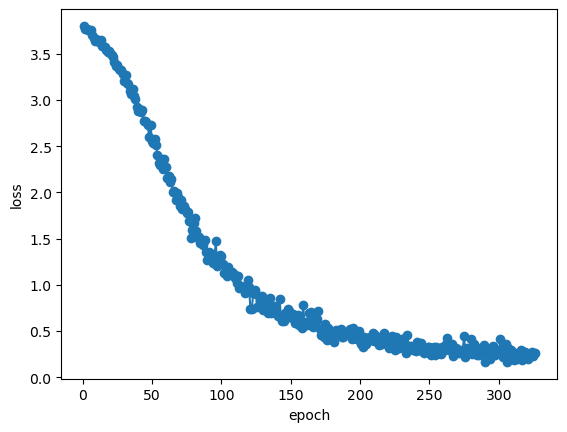

In [39]:
import matplotlib.pyplot as plt

# Plot Error
plt.plot(1 + np.arange(326), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

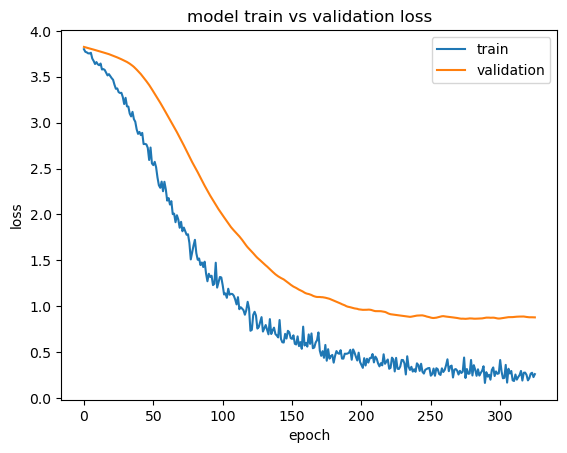

In [40]:
# Plot Error
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
# Save model
model.save('chatbot_model')

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


# Chatbot AI

In [ ]:
# def clean_up_classes(sentence):
#     """
#     Tokenizes and stems the input sentence using Sastrawi stemmer.

#     Args:
#     sentence (str): Input sentence to be tokenized and stemmed.

#     Returns:
#     list: List of tokenized and stemmed words.
#     """
#     sentence_words = nltk.word_tokenize(sentence)
#     sentence_words = [stemmer.stem(word) for word in sentence_words]
#     return sentence_words

# def bag_of_words(sentence):
#     """
#     Converts a sentence into a bag-of-words representation based on the loaded vocabulary.

#     Parameters:
#     ----------
#     sentence : str
#         Input sentence to be converted.

#     Returns:
#     --------
#     numpy.ndarray
#         Bag-of-words representation of the input sentence.
#     """
#     # Tokenize and stem the input sentence
#     sentence_words = clean_up_classes(sentence)
    
#     bag = [0] * len(words)
#     for w in sentence_words:
#         for i, word in enumerate(words):
#             if word == w:
#                 bag[i] = 1
#     return np.array(bag)

# def predict_class(sentence):
#     """
#     Predicts the intent class of the input sentence using the loaded model.

#     Parameters:
#     ----------
#     sentence : str 
#         Input sentence for intent prediction.

#     Returns:
#     --------
#     list: 
#         List of dictionaries containing the predicted intent and its probability.
#     """
#     sentence_words = clean_up_classes(sentence)

#     bag = [0] * len(words)
#     for w in sentence_words:
#         for i, word in enumerate(words):
#             if word == w:
#                 bag[i] = 1
#     return np.array(bag)

# def predict_class(sentence):
#     """
#     Predicts the intent class of the input sentence using the loaded model.

#     Parameters:
#     ----------
#     sentence : str 
#         Input sentence for intent prediction.

#     Returns:
#     --------
#     list: 
#         List of dictionaries containing the predicted intent and its probability.
#     """
#     # Convert the sentence into a bag-of-words representation
#     bow = bag_of_words(sentence)

#     # Make a prediction using the loaded model
#     res = model.predict(np.array([bow]))[0]
    
#     # Apply a threshold to filter out predictions with low probabilities
#     ERROR_THRESHOLD = 0.25
    
#     results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    
#     return_list = []
#     for r in results:
#         return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    
#     return return_list

In [ ]:
# def get_response(intents_list, intents_json):
#     """
#     Retrieves a random response for the predicted intent from the loaded data.

#     Parameters:
#     -----------
#     intents_list : list 
#         List of dictionaries containing the predicted intent and its probability.
#     intents_json : dict 
#         Dictionary containing the intent data loaded from the JSON file.

#     Returns:
#     --------
#     str: 
#         Randomly selected response for the predicted intent.
#     """
#     # If intents_list is empty, set a default response
#     if not intents_list:
#         return "Maaf, saya tidak mengerti pertanyaan Anda."

#     # Extract the predicted intent
#     tag = intents_list[0]['intent']
    
#     # Find the intent with matching tag
#     matching_intent = next((intent for intent in intents_json['intents'] if intent['tag'] == tag), None)

#     # If matching intent is found, choose a random response
#     if matching_intent:
#         result = random.choice(matching_intent['responses'])
#     else:
#         # If no matching intent is found, set a default response
#         result = "Maaf, saya tidak mengerti pertanyaan Anda."

#     return result


In [ ]:
# print("Hallo Bot Zen akan membantu Anda")

# while True:
#     message = input("You: ")
    
#     # Check if the user wants to exit
#     if message.lower() == 'exit':
#         print("Bot: Goodbye!")
#         break
    
#     ints = predict_class(message)
#     res = get_response(ints, data)
#     print("Bot:", res)